In [8]:
import pandas
import konlpy
import gensim
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.initializers import Constant

print(pandas.__version__)
print(konlpy.__version__)
print(gensim.__version__)

1.3.3
0.5.2
4.1.2


In [2]:
import pandas as pd

train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
from konlpy.tag import Mecab
import numpy as np
from collections import Counter

tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

def load_data(train_data, test_data, num_words=10000):
    train_data = train_data.drop_duplicates(subset=['document']).dropna()
    test_data = test_data.drop_duplicates(subset=['document']).dropna()
    
    def tokenize_and_remove_stopwords(text):
        tokens = tokenizer.morphs(str(text))  
        return [word for word in tokens if word not in stopwords] 

    train_texts = [tokenize_and_remove_stopwords(text) for text in train_data['document']]
    test_texts = [tokenize_and_remove_stopwords(text) for text in test_data['document']]
    
    word_counts = Counter(word for text in train_texts for word in text)  # 단어 빈도수 계산
    most_common_words = word_counts.most_common(num_words - 4)  # 상위 num_words 단어만 선택
    
    word_to_index = {word: i+4 for i, (word, _) in enumerate(most_common_words)}
    word_to_index["<PAD>"] = 0
    word_to_index["<BOS>"] = 1
    word_to_index["<UNK>"] = 2
    word_to_index["<UNUSED>"] = 3

    def text_to_sequence(texts):
        return [[word_to_index.get(word, word_to_index["<UNK>"]) for word in text] for text in texts]

    X_train = text_to_sequence(train_texts)
    X_test = text_to_sequence(test_texts)
    y_train = np.array(train_data['label'])
    y_test = np.array(test_data['label'])

    return X_train, y_train, X_test, y_test, word_to_index
    
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data)

In [4]:
index_to_word = {index:word for word, index in word_to_index.items()}

In [5]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [9]:
# 3) 데이터 분석 및 가공
train_lengths = [len(x) for x in X_train]
print("평균 문장 길이:", np.mean(train_lengths))
print("최대 문장 길이:", np.max(train_lengths))
print("문장 길이 표준편차:", np.std(train_lengths))

maxlen = int(np.mean(train_lengths) + 2 * np.std(train_lengths))
print("패딩에 사용할 최대 문장 길이:", maxlen)

# pad_sequences를 사용하여 모든 문장의 길이를 maxlen으로 통일
X_train_pad = pad_sequences(X_train, maxlen=maxlen, padding='post', truncating='post')
X_test_pad  = pad_sequences(X_test,  maxlen=maxlen, padding='post', truncating='post')

평균 문장 길이: 15.98170773419436
최대 문장 길이: 116
문장 길이 표준편차: 12.82473766384545
패딩에 사용할 최대 문장 길이 (maxlen): 41


In [12]:
# 4) 모델 구성 및 validation set 구성
val_size = int(0.2 * len(X_train_pad))
X_val = X_train_pad[:val_size]
y_val = y_train[:val_size]
X_train_final = X_train_pad[val_size:]
y_train_final = y_train[val_size:]

vocab_size = len(word_to_index)
print("어휘 사전 크기:", vocab_size)

# 모델 1: Embedding + LSTM ---
model_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
    tf.keras.layers.LSTM(64),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_lstm.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_lstm.summary()

# 모델 2: Embedding + CNN ---
model_cnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
    tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Conv1D(64, kernel_size=5, activation='relu'),
    tf.keras.layers.GlobalMaxPooling1D(),
    tf.keras.layers.Dense(1, activation='sigmoid')
])
model_cnn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model_cnn.summary()
# 모델 3 : Embedding + Simple RNN
model_rnn = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=vocab_size, output_dim=128, input_length=maxlen),
    tf.keras.layers.SimpleRNN(64),  
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_rnn.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

model_rnn.summary()


어휘 사전 크기: 10000
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 41, 128)           1280000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 1,329,473
Trainable params: 1,329,473
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 41, 128)           1280000   
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 37, 64)            41024     
______

In [13]:
# 5) 모델 학습 

epochs = 5       
batch_size = 512

print("\n----- 모델 1: Embedding + LSTM -----")
history_lstm = model_lstm.fit(X_train_final, y_train_final,
                              epochs=epochs,
                              batch_size=batch_size,
                              validation_data=(X_val, y_val),
                              verbose=1)

print("\n----- 모델 2: Embedding + CNN -----")
history_cnn = model_cnn.fit(X_train_final, y_train_final,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_val, y_val),
                            verbose=1)

print("\n----- 모델 3 (Embedding + Simple RNN) 학습 -----")
history_rnn = model_rnn.fit(X_train_final, y_train_final,
                            epochs=epochs,
                            batch_size=batch_size,
                            validation_data=(X_val, y_val),
                            verbose=1)


----- 모델 1: Embedding + LSTM -----
Epoch 1/5
229/229 [==============================] - 6s 10ms/step - loss: 0.4493 - accuracy: 0.7687 - val_loss: 0.3872 - val_accuracy: 0.8241
Epoch 2/5
229/229 [==============================] - 2s 7ms/step - loss: 0.3322 - accuracy: 0.8569 - val_loss: 0.3420 - val_accuracy: 0.8502
Epoch 3/5
229/229 [==============================] - 2s 7ms/step - loss: 0.3028 - accuracy: 0.8705 - val_loss: 0.3436 - val_accuracy: 0.8494
Epoch 4/5
229/229 [==============================] - 2s 7ms/step - loss: 0.2738 - accuracy: 0.8835 - val_loss: 0.3582 - val_accuracy: 0.8521
Epoch 5/5
229/229 [==============================] - 2s 7ms/step - loss: 0.2486 - accuracy: 0.8951 - val_loss: 0.3501 - val_accuracy: 0.8525

----- 모델 2: Embedding + CNN -----
Epoch 1/5
229/229 [==============================] - 4s 9ms/step - loss: 0.4158 - accuracy: 0.8039 - val_loss: 0.3356 - val_accuracy: 0.8544
Epoch 2/5
229/229 [==============================] - 2s 7ms/step - loss: 0.3017 - 

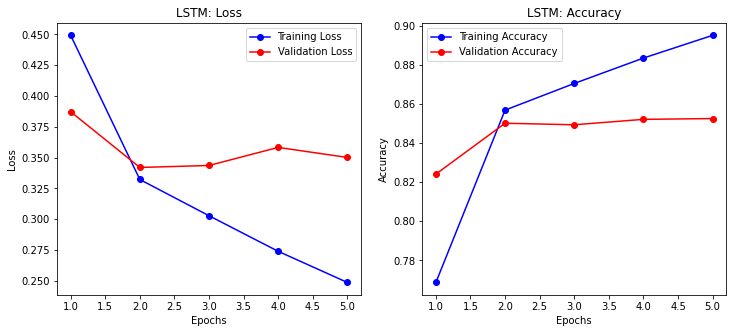

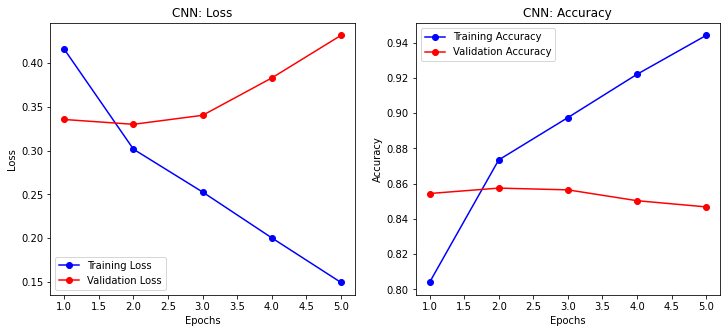

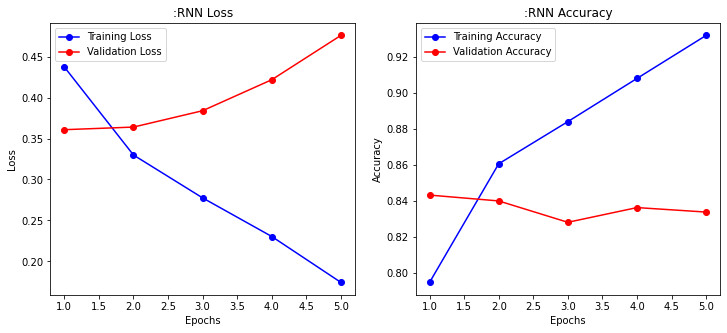

In [15]:
# 6) Loss, Accuracy 그래프 시각화
# -----------------------------
def plot_history(history, title_prefix=""):
    history_dict = history.history
    epochs_range = range(1, len(history_dict['loss']) + 1)
    
    plt.figure(figsize=(12,5))
    
    # Loss 그래프
    plt.subplot(1,2,1)
    plt.plot(epochs_range, history_dict['loss'], 'bo-', label='Training Loss')
    plt.plot(epochs_range, history_dict['val_loss'], 'ro-', label='Validation Loss')
    plt.title(title_prefix + "Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    
    # Accuracy 그래프
    plt.subplot(1,2,2)
    plt.plot(epochs_range, history_dict['accuracy'], 'bo-', label='Training Accuracy')
    plt.plot(epochs_range, history_dict['val_accuracy'], 'ro-', label='Validation Accuracy')
    plt.title(title_prefix + "Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    
    plt.show()

# 각 모델의 학습 그래프 시각화
plot_history(history_lstm, title_prefix="LSTM: ")
plot_history(history_cnn, title_prefix="CNN: ")
plot_history(history_rnn, title_prefix=":RNN ")


In [28]:
import numpy as np
from gensim.models import KeyedVectors


embedding_layer = model_lstm.layers[0]   
embedding_weights = embedding_layer.get_weights()[0]  

vocab_size, embedding_dim = embedding_weights.shape
print(f"자체 학습 임베딩 크기: ({vocab_size}, {embedding_dim})")

# 2) KeyedVectors 객체 초기화
kv_self = KeyedVectors(vector_size=embedding_dim)

# 2-1) 단어 리스트와 벡터 리스트를 생성
word_list = []
vector_list = []

for idx in range(vocab_size):
    word = index_to_word.get(idx, None)
    if word is not None and len(word) > 0:  # 유효한 단어라면
        word_list.append(word)
        vector_list.append(embedding_weights[idx])

word_list = np.array(word_list)
vector_list = np.array(vector_list)  #


kv_self.index_to_key = list(word_list)
kv_self.key_to_index = {word: i for i, word in enumerate(word_list)}
kv_self.vectors = vector_list

# 3) "영화"와 유사한 단어 Top 5

similar_words = kv_self.most_similar("영화", topn=5)
print("[자체 학습 임베딩] '영화'와 유사한 단어 Top5:")
for w, sim in similar_words:
    print(f"  {w}: {sim:.4f}")

    
    
from gensim.models import Word2Vec

# Word2Vec 모델 로드 
word2vec_model_path = os.path.expanduser('~/data/word2vec_ko.model')
w2v_model = Word2Vec.load(word2vec_model_path)  # load() 방식 사용

# '영화' 단어와 유사한 단어 5개

similar_words_pretrained = w2v_model.wv.most_similar("영화", topn=5)
print("[사전학습 임베딩] '영화'와 유사한 단어:")
    for w, sim in similar_words_pretrained:
        print(f" {w}: {sim:.4f}")





자체 학습 임베딩 크기: (10000, 128)
KeyedVectors 구성 완료!
[자체 학습 임베딩] '영화'와 유사한 단어 Top5:
  왔: 0.4660
  습니다: 0.4644
  봐도: 0.4444
  으랴: 0.4266
  하울: 0.4253
[사전학습 임베딩] '영화'와 유사한 단어:
 드라마: 0.8419
 뮤지컬: 0.7775
 코미디: 0.7489
 다큐멘터리: 0.7401
 헐리우드: 0.7398


In [31]:
embedding_dim = w2v_model.vector_size  # Word2Vec 모델 벡터 차원 
embedding_matrix = np.random.uniform(-0.05, 0.05, (vocab_size, embedding_dim))

# Word2Vec 벡터를 embedding_matrix에 복사
for word, idx in word_to_index.items():
    if idx < 4:  
        continue
    if word in w2v_model.wv:
        embedding_matrix[idx] = w2v_model.wv[word]

# 2. LSTM 모델 구성 

import tensorflow as tf
from tensorflow.keras.initializers import Constant

model_w2v_lstm = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        embeddings_initializer=Constant(embedding_matrix),  
        input_length=X_train_pad.shape[1], 
        trainable=True  
    ),
    tf.keras.layers.LSTM(128, dropout=0.3),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model_w2v_lstm.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_w2v_lstm.summary()


# 3. 학습 

from tensorflow.keras.callbacks import EarlyStopping


val_size = int(len(X_train_pad) * 0.2)
X_val = X_train_pad[:val_size]
y_val = y_train[:val_size]
X_train_final = X_train_pad[val_size:]
y_train_final = y_train[val_size:]

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=3,
    restore_best_weights=True
)

epochs = 20
batch_size = 512

history_w2v_lstm = model_w2v_lstm.fit(
    X_train_final, y_train_final,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1
)

# 4. 테스트 셋 평가
test_loss, test_acc = model_w2v_lstm.evaluate(X_test_pad, y_test, verbose=2)
print(f"\n[Word2Vec + LSTM] 테스트셋 결과 - Loss: {test_loss:.4f}, Accuracy: {test_acc:.4f}")

# 정확도 85% 이상 달성 확인
if test_acc >= 0.85:
    print("85% 이상의 정확도")





Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 41, 100)           1000000   
_________________________________________________________________
lstm_3 (LSTM)                (None, 128)               117248    
_________________________________________________________________
dense_8 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 1)                 65        
Total params: 1,125,569
Trainable params: 1,125,569
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
229/229 [==============================] - 4s 13ms/step - loss: 0.5455 - accuracy: 0.7151 - val_los

## 회고




gensim을 처음써보는거라 어려웠다 
konlpy를 쓸때 예전부터 항상 설치에러가 나서 그 이후로 시도도 안해봤는데 다행히 에러가 안나서 편안하게 코딩할수있었다
Word2Vec + LSTM 으로 간단하게 85퍼 이상의 정확도가 나와서 다행이다
